In [1]:
pip install osmnx


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.9/99.9 kB 1.9 MB/s eta 0:00:00


In [2]:
# Gerekli kütüphaneleri yüklüyoruz
import osmnx as ox
import math
import heapq
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx


In [11]:

from google.colab import files
uploaded = files.upload()

import pandas as pd

# Dosyanın tam yolunu kullanarak veriyi içe aktar
df = pd.read_csv("abs-gps.csv")

# İlk birkaç satırı kontrol edelim
print(df.head())



Saving abs-gps.csv to abs-gps (1).csv
     timestamp  abs-latitude  abs-longitude  abs-altitude
0  1203.094660     -0.001980       0.000376      0.208233
1  1203.594883     -0.002000       0.000376      0.208636
2  1204.094388     -0.002021       0.000377      0.208832
3  1204.590754     -0.002040       0.000378      0.208895
4  1205.091595     -0.002060       0.000381      0.208347


In [12]:
# Latitude ve longitude değerlerini tuple listesine çeviriyoruz
coordinates = list(zip(df['abs-latitude'], df['abs-longitude']))



In [13]:
# İki GPS noktası arasındaki mesafeyi hesaplamak için Haversine formülü
def haversine(coord1, coord2):
    R = 6371  # Dünya yarıçapı (km)
    lat1, lon1 = coord1
    lat2, lon2 = coord2
    phi1, phi2 = math.radians(lat1), math.radians(lat2)
    dphi = math.radians(lat2 - lat1)
    dlambda = math.radians(lon2 - lon1)

    a = math.sin(dphi/2)**2 + math.cos(phi1)*math.cos(phi2)*math.sin(dlambda/2)**2
    return 2 * R * math.atan2(math.sqrt(a), math.sqrt(1 - a))


In [14]:
# Mesafe ve hız hesaplamak için numpy ile çalışıyoruz

def haversine_np(lat1, lon1, lat2, lon2):
    R = 6371000  # metre cinsinden Dünya yarıçapı
    phi1, phi2 = np.radians(lat1), np.radians(lat2)
    dphi = np.radians(lat2 - lat1)
    dlambda = np.radians(lon2 - lon1)

    a = np.sin(dphi / 2)**2 + np.cos(phi1) * np.cos(phi2) * np.sin(dlambda / 2)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
    return R * c

# Mesafe ve hız dizileri
distances = [0]
speeds = [0]

for i in range(1, len(df)):
    lat1, lon1 = df.loc[i-1, ['abs-latitude', 'abs-longitude']]
    lat2, lon2 = df.loc[i, ['abs-latitude', 'abs-longitude']]
    time1, time2 = df.loc[i-1, 'timestamp'], df.loc[i, 'timestamp']

    dt = time2 - time1
    d = haversine_np(lat1, lon1, lat2, lon2)
    v = d / dt if dt != 0 else 0

    distances.append(d)
    speeds.append(v)

df['distance'] = distances
df['speed'] = speeds

# Kavşaklar genelde aracın yavaşladığı yerlerdir
speed_threshold = 2.0  # m/s
df['is_intersection'] = df['speed'] < speed_threshold


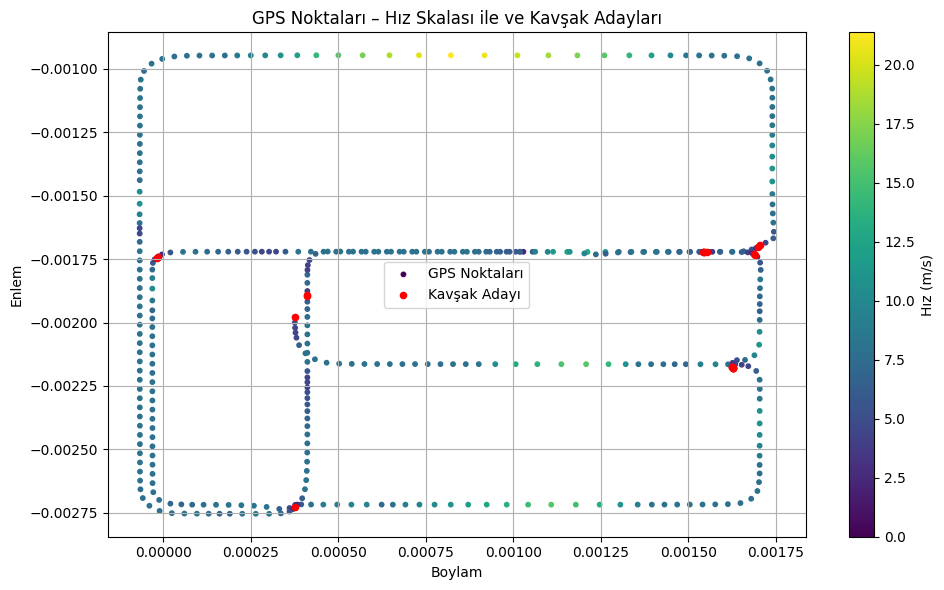

In [15]:
plt.figure(figsize=(10, 6))

scatter = plt.scatter(
    df['abs-longitude'], df['abs-latitude'],
    c=df['speed'], cmap='viridis', s=10, label='GPS Noktaları'
)

plt.scatter(
    df[df['is_intersection']]['abs-longitude'],
    df[df['is_intersection']]['abs-latitude'],
    color='red', label='Kavşak Adayı', s=20
)

plt.colorbar(scatter, label="Hız (m/s)")
plt.xlabel("Boylam")
plt.ylabel("Enlem")
plt.title("GPS Noktaları – Hız Skalası ile ve Kavşak Adayları")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
